In [5]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.graph_objs as go
import plotly
#import plotly.plotly as py
import plotly.figure_factory as ff
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)


import gc
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from catboost import CatBoostClassifier
from sklearn import svm
import lightgbm as lgb
from lightgbm import LGBMClassifier
import xgboost as xgb

pd.set_option('display.max_columns', 100)


RFC_METRIC = 'gini'  #metric used for RandomForrestClassifier
NUM_ESTIMATORS = 100 #number of estimators used for RandomForrestClassifier
NO_JOBS = 4 #number of parallel jobs used for RandomForrestClassifier


#TRAIN/VALIDATION/TEST SPLIT
#VALIDATION
VALID_SIZE = 0.20 # simple validation using train_test_split
TEST_SIZE = 0.20 # test size using_train_test_split

#CROSS-VALIDATION
NUMBER_KFOLDS = 5 #number of KFolds for cross-validation



RANDOM_STATE = 2018

MAX_ROUNDS = 1000 #lgb iterations
EARLY_STOP = 50 #lgb early stop
OPT_ROUNDS = 1000  #To be adjusted based on best validation rounds
VERBOSE_EVAL = 50 #Print out metric result

IS_LOCAL = False

import os

if(IS_LOCAL):
    PATH="./input/credit-card-fraud-detection"
else:
    PATH="./input"
print(os.listdir(PATH))

#Read and check the data
data_df = pd.read_csv(PATH+"/creditcard.csv")



print("Credit Card Fraud Detection data -  rows:",data_df.shape[0]," columns:", data_df.shape[1])

#--- describe the dataset

print(data_df.describe())


# ------- check missing data ----
total = data_df.isnull().sum().sort_values(ascending = False)
percent = (data_df.isnull().sum()/data_df.isnull().count()*100).sort_values(ascending = False)
pd.concat([total, percent], axis=1, keys=['Total', 'Percent']).transpose()





# now let's do the data exploration

#first do the transaction over the time


# ----Transaction amount




['creditcard.csv']
Credit Card Fraud Detection data -  rows: 284807  columns: 31
                Time            V1            V2            V3            V4  \
count  284807.000000  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean    94813.859575  1.165980e-15  3.416908e-16 -1.373150e-15  2.086869e-15   
std     47488.145955  1.958696e+00  1.651309e+00  1.516255e+00  1.415869e+00   
min         0.000000 -5.640751e+01 -7.271573e+01 -4.832559e+01 -5.683171e+00   
25%     54201.500000 -9.203734e-01 -5.985499e-01 -8.903648e-01 -8.486401e-01   
50%     84692.000000  1.810880e-02  6.548556e-02  1.798463e-01 -1.984653e-02   
75%    139320.500000  1.315642e+00  8.037239e-01  1.027196e+00  7.433413e-01   
max    172792.000000  2.454930e+00  2.205773e+01  9.382558e+00  1.687534e+01   

                 V5            V6            V7            V8            V9  \
count  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean   9.604066e-16  1.490107e-15 -5.556

,Class,V14,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V15,Amount,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Time
Total,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Percent,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
# ---- checking the data unbalance -------

temp = data_df["Class"].value_counts()
df = pd.DataFrame({'Class': temp.index,'values': temp.values})

trace = go.Bar(
    x = df['Class'],y = df['values'],
    name="Credit Card Fraud Class - data unbalance (Not fraud = 0, Fraud = 1)",
    marker=dict(color="Red"),
    text=df['values']
)
data = [trace]
layout = dict(title = 'Credit Card Fraud Class - data unbalance (Not fraud = 0, Fraud = 1)',
          xaxis = dict(title = 'Class', showticklabels=True),
          yaxis = dict(title = 'Number of transactions'),
          hovermode = 'closest',width=600
         )
fig = dict(data=data, layout=layout)


iplot(fig, filename='class')

# Only 492 (or 0.172%) of transaction are fraudulent. That means the data is highly unbalanced with respect with target variable Class.



In [3]:
class_0 = data_df.loc[data_df['Class'] == 0]["Time"]
class_1 = data_df.loc[data_df['Class'] == 1]["Time"]
#plt.figure(figsize = (14,4))
#plt.title('Credit Card Transactions Time Density Plot')
#sns.set_color_codes("pastel")
#sns.distplot(class_0,kde=True,bins=480)
#sns.distplot(class_1,kde=True,bins=480)
#plt.show()
hist_data = [class_0, class_1]
group_labels = ['Not Fraud', 'Fraud']

fig = ff.create_distplot(hist_data, group_labels, show_hist=False, show_rug=False)
fig['layout'].update(title='Credit Card Transactions Time Density Plot', xaxis=dict(title='Time [s]'))
iplot(fig, filename='dist_only')


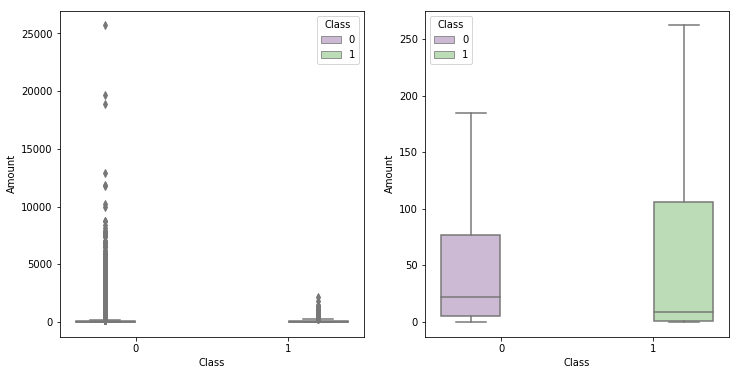

In [2]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))
s = sns.boxplot(ax = ax1, x="Class", y="Amount", hue="Class",data=data_df, palette="PRGn",showfliers=True)
s = sns.boxplot(ax = ax2, x="Class", y="Amount", hue="Class",data=data_df, palette="PRGn",showfliers=False)
plt.show();

In [6]:
fraud = data_df.loc[data_df['Class'] == 1]

trace = go.Scatter(
    x = fraud['Time'],y = fraud['Amount'],
    name="Amount",
     marker=dict(
                color='rgb(238,23,11)',
                line=dict(
                    color='red',
                    width=1),
                opacity=0.5,
            ),
    text= fraud['Amount'],
    mode = "markers"
)
data = [trace]
layout = dict(title = 'Amount of fraudulent transactions',
          xaxis = dict(title = 'Time [s]', showticklabels=True), 
          yaxis = dict(title = 'Amount'),
          hovermode='closest'
         )
fig = dict(data=data, layout=layout)
iplot(fig, filename='fraud-amount')


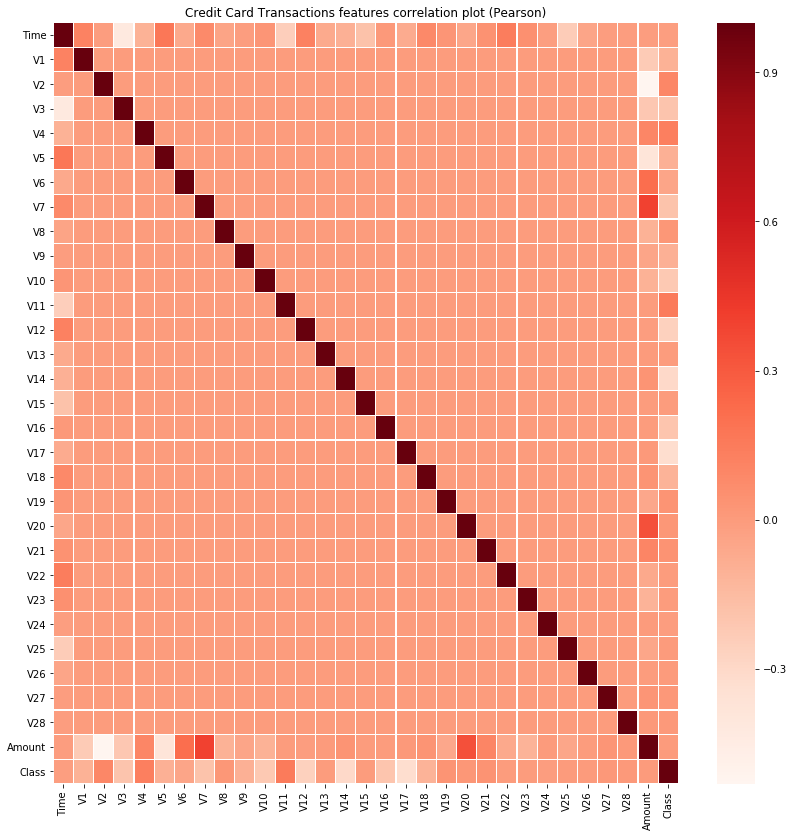

In [7]:
# feature correlation
plt.figure(figsize = (14,14))
plt.title('Credit Card Transactions features correlation plot (Pearson)')
corr = data_df.corr()
sns.heatmap(corr,xticklabels=corr.columns,yticklabels=corr.columns,linewidths=.1,cmap="Reds")
plt.show()


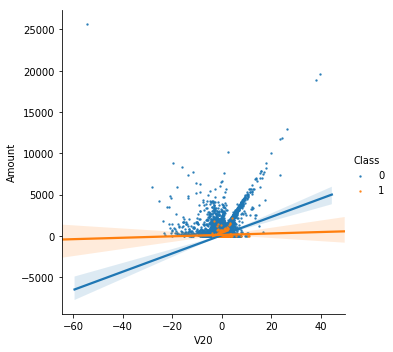

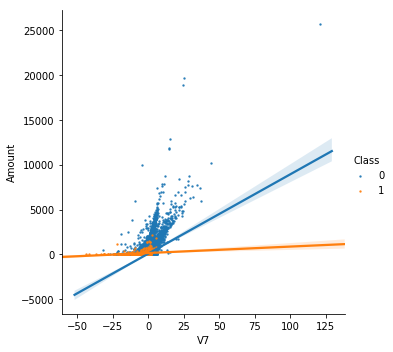

In [9]:
s = sns.lmplot(x='V20', y='Amount',data=data_df, hue='Class', fit_reg=True,scatter_kws={'s':2})
s = sns.lmplot(x='V7', y='Amount',data=data_df, hue='Class', fit_reg=True,scatter_kws={'s':2})
plt.show()

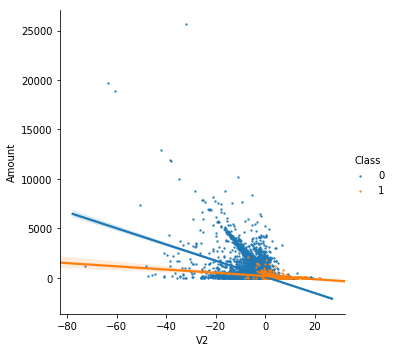

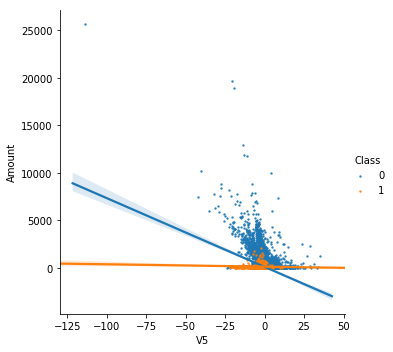

In [10]:
s = sns.lmplot(x='V2', y='Amount',data=data_df, hue='Class', fit_reg=True,scatter_kws={'s':2})
s = sns.lmplot(x='V5', y='Amount',data=data_df, hue='Class', fit_reg=True,scatter_kws={'s':2})
plt.show()

<Figure size 432x288 with 0 Axes>

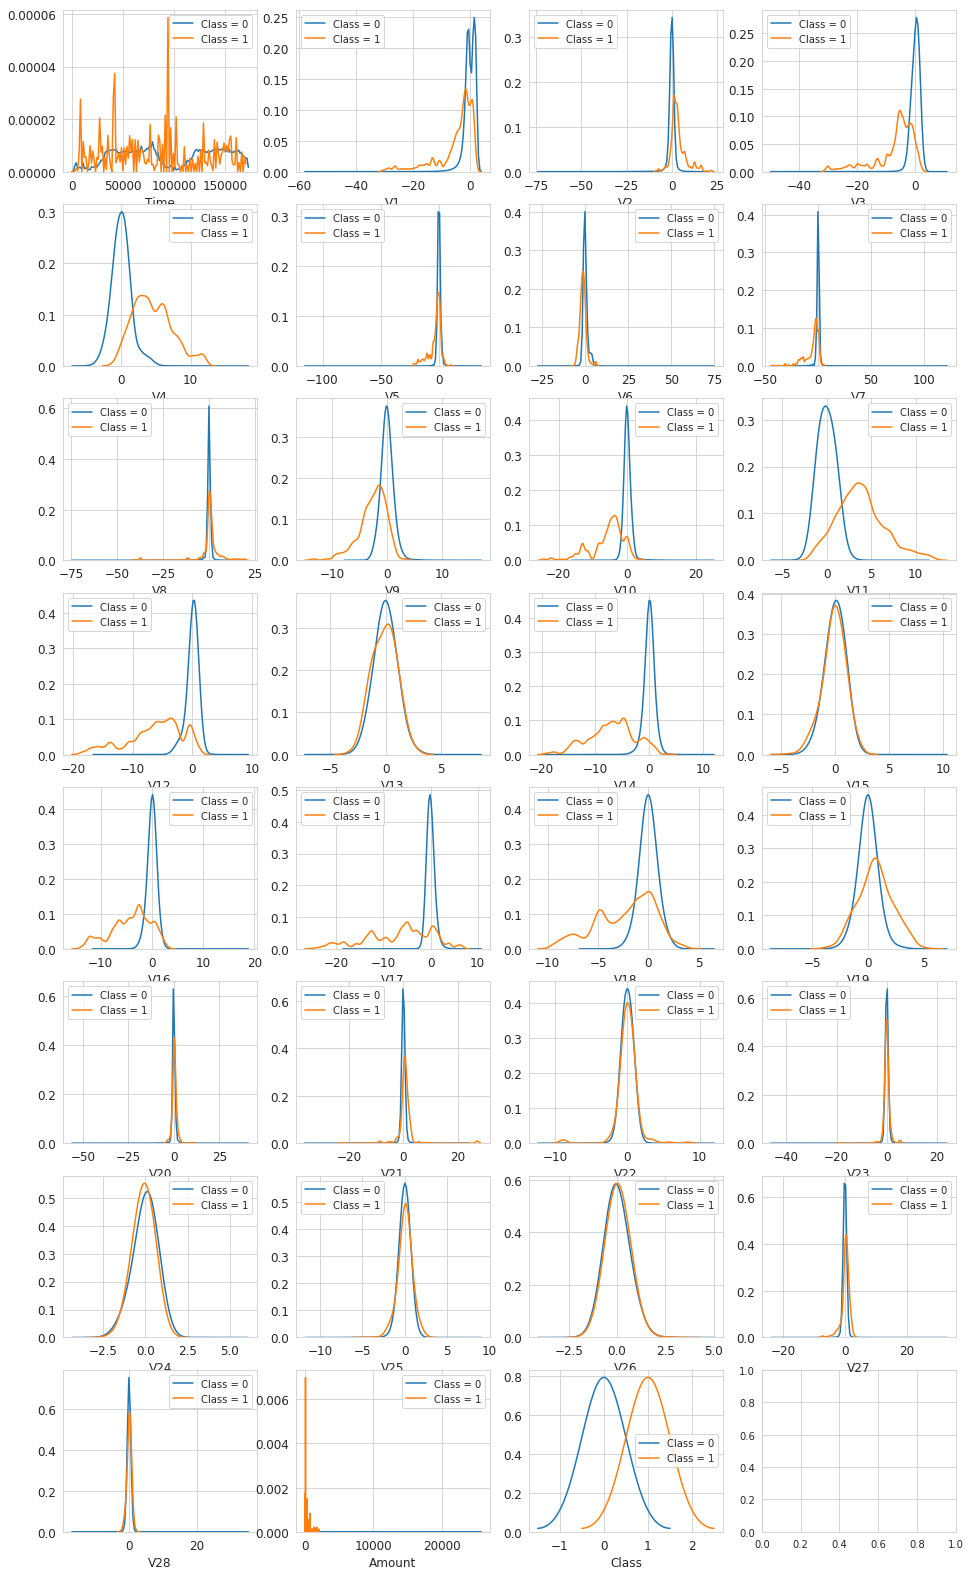

In [11]:
var = data_df.columns.values

i = 0
t0 = data_df.loc[data_df['Class'] == 0]
t1 = data_df.loc[data_df['Class'] == 1]

sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(8,4,figsize=(16,28))

for feature in var:
    i += 1
    plt.subplot(8,4,i)
    sns.kdeplot(t0[feature], bw=0.5,label="Class = 0")
    sns.kdeplot(t1[feature], bw=0.5,label="Class = 1")
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show();